In [1]:
#| default_exp datasets

In [2]:
#|export
from __future__ import annotations
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F

from miniai.training import *
#from ../F22G.training import *
import torchvision.transforms.functional as TF
from fastcore.test import test_close

In [3]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

In [4]:
import logging
logging.disable(logging.WARNING)

## Hugging Face Datasets

After `pip install datasets` we can import the following:  

In [5]:
from datasets import load_dataset,load_dataset_builder

The dataset "Fashion_mnist", like MNIST, has 28x28 grayscale images, 10 categories, 60,000 training and 10,000 test examples. 
It's a direct drop-in replacement for MNIST.
We just give the name to `load_dataset_builder`, to get a `ds_builder` which (used to have metadata about this dataset, e.g., in `.info.description` but now it is empty): 

In [6]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
print(ds_builder.info)

DatasetInfo(description='', citation='', homepage='', license='', features={'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}, post_processed=None, supervised_keys=None, builder_name='parquet', dataset_name='fashion_mnist', config_name='fashion_mnist', version=0.0.0, splits={'train': SplitInfo(name='train', num_bytes=31304707, num_examples=60000, shard_lengths=None, dataset_name='fashion_mnist'), 'test': SplitInfo(name='test', num_bytes=5235160, num_examples=10000, shard_lengths=None, dataset_name='fashion_mnist')}, download_checksums={'hf://datasets/fashion_mnist@531be5e2ccc9dba0c201ad3ae567a4f3d16ecdd2/fashion_mnist/train-00000-of-00001.parquet': {'num_bytes': 30931277, 'checksum': None}, 'hf://datasets/fashion_mnist@531be5e2ccc9dba0c201ad3ae567a4f3d16ecdd2/fashion_mnist/test-00000-of-00001.parquet': {'num_bytes': 5175617, 'checksum': None


The dataset builder will tell us what's in this dataset, via dictionaries rather  than tuples.

In [7]:
ds_builder.info.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

So there's `image` of type `Image`, and `label` of type `ClassLabel`, 10 classes and these are the names of the classes. 

`info.splits` is the size  of the training/test split and the number of examples.

In [8]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31304707, num_examples=60000, shard_lengths=None, dataset_name='fashion_mnist'),
 'test': SplitInfo(name='test', num_bytes=5235160, num_examples=10000, shard_lengths=None, dataset_name='fashion_mnist')}

`load_dataset()` downloads the dataset, caches it and returns a dataset  dictionary. 
A dataset dictionary is like what Fastai calls the datasets class. 
HF calls it the `DatasetDict` class, and it contains a `train` and a `test` datasets,
which are like the datasets that we created in the previous notebook.  

In [9]:
dsd = load_dataset(name)
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

Let's take the `train` and the `test` and examine items from the `dsd` dictionary. We'll assign these items to variables and then inspect their initial entries. As expected, each entry contains an `image` and a `label`. Instead of tuples, we now have dictionaries with 'x' and 'y' keys, representing the image and label respectively in this instance.

In [10]:
train,test = dsd['train'],dsd['test']
train[0], test[0]

({'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  'label': 9},
 {'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  'label': 9})

To avoid writing image and  label in strings, we store them as `x` and `y`.

In [11]:
x,y = ds_builder.info.features
x,y

('image', 'label')

We grab the first image `[0][x]`. 

In [12]:
img = train[0][x]
img 

Lets grab the first 5 images and the first 5 labels.

In [13]:
xb = train[:5][x]
yb = train[:5][y]
yb

[9, 0, 0, 3, 0]

We know what the names of the labels are.

In [14]:
featy = train.features[y]
featy

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

We can see what the `yb` map to by grabbing those features. 

In [15]:
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [16]:
train['label'][:5]

[9, 0, 0, 3, 0]

The collate function `collate_fn` returns a dictionary (a common practice for Hugging Face).
It processes a batch `b` by converting each image to a tensor and stacking them. 
It then retrieves the labels `o[y]` and stacks these integers (no explicit stacking needed as it's already a tensor). 
Finally, it returns the processed images and labels within a dictionary.

In [17]:
def collate_fn(b):
    return {x:torch.stack([TF.to_tensor(o[x]) for o in b]),
            y:tensor([o[y] for o in b])}

The `collate_fn` receives the batch `b` directly. 
It iterates through each item `o in b`, extracts the value associated with the key `o[x]`, and converts it into a tensor. These tensors are then stacked together. 
This "manual" approach offers a straightforward way to handle collation, especially useful for custom operations where framework abstractions might be less desirable.

HF expects transforms to return the new version of the data (below `b`)

We create a DataLoader `dl` using `collate_fn`, with `batch_size=16`.
We grab one batch `b`, `b[x].shape` is a `[16,1,28,28]` (16 images, 1 channel, 28x28).
The 16 `y` labels of the batch `b[y]` are there.

In [18]:
dl = DataLoader(train, collate_fn=collate_fn, batch_size=16)
b = next(iter(dl))
b[x].shape,b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

Notice the absence of any explicit data transformations. All the data processing is intentionally placed within the `collate_fn` function. This strategy provides a way to exert direct control over the data preparation pipeline, effectively "skipping" the inherent abstractions of the framework and encapsulating all the necessary operations within the collate function.

In [19]:
def transforms(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]
    return b

#### [with_transform](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.with_transform)

Hugging Face datasets provide a `.with_transform(t)` method, available on a dataset object `D`, that applies the specified transform `t` to batches in real-time when the `__getitem__` method is invoked. 
This function `t` is applied to each individual element within `D`, facilitating dynamic data augmentation. Given that the transformation occurs upon each call to `__getitem__`, it is executed on-the-fly. 
As `tds` represents a dataset, it is compatible with PyTorch's DataLoader. 
<br>
**NB:** 
* PyTorch's default collation mechanism handles dictionaries of tensors, thus obviating the need for a custom collation function. 
* Hugging Face datasets expect the `with_transform` function to return the updated dataset object.

In [20]:
tds = train.with_transform(transforms)
dl = DataLoader(tds, batch_size=16)
b = next(iter(dl))
b[x].shape,b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

We aim to define `_transformi` to operate in-place, modifying the data directly without an explicit return. 
We define `_transformi` similarly to prior transforms, but crucially, it lacks a return statement, performing its operations in-place as before, but without returning the modified data.

In [21]:
def _transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

Note: Programming trick: To make an in-place function like `_transformi` return the modified value, we can define a higher-order function `inplace(f)`. This function takes `f` as input, calls `f`, and then returns the (now modified) value. Hugging Face could utilize this to adapt in-place transformations for their pipeline.

In essence, `inplace` acts as a wrapper around another function f. It creates a new function _f that does the following:
* Takes some input (b).
* Calls the original function f on that input (b), allowing f to modify b in-place.
* Returns the (potentially modified) input b.

In [22]:
#|export
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

We take our in-place transformation function, `_transformi`, and pass it to the `inplace` function (a function-generating function). 
This creates a new function, which we'll call `transformi`. 
This `transformi` function is essentially the returning version of our original in-place operation. 
The `inplace(f)` function takes a function `A` and returns a new function `B`. 
When called, `B` executes `A` and then returns the (potentially modified) result. 
Therefore, `transformi` is now in a format that Hugging Face's `with_transform()` can utilize, allowing the same in-place modification to be applied and then returned as expected within the Hugging Face data processing pipeline.

In [23]:
transformi = inplace(_transformi)

In [24]:
r = train.with_transform(transformi)[0]
r[x].shape,r[y]

(torch.Size([784]), 9)

This is a common Python pattern, so there is a decorator (synctactic sugar), using @inplace which will replace the call with the inplace.

In [25]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

Now we can create `tdsf` a transformed dataset using `transformi`.

In [26]:
tdsf = train.with_transform(transformi)
r = tdsf[0]
r[x].shape,r[y]

(torch.Size([784]), 9)

### [itemgetter](https://docs.python.org/3/library/operator.html?highlight=itemgetter#operator.itemgetter)
`itemgetter(item, ...) --> itemgetter object`
<br>
Return a callable object that fetches the given item(s) from its operand.
After `f = itemgetter(2)`, the call `f(r)` returns `r[2]`.
After `g = itemgetter(2, 5, 3)`, the call `g(r)` returns (`r[2], r[5], r[3]`)

We can automate with `itemgetter()`, a function that returns a function.
Below example, `itemgetter` creates a function `ig(d)` that gets the `a` and `c` items from a dictionary 
(or something that looks like a dictionary). 
`d` is a dictionary, `ig(d)` will return the `a` and `c` values in `d`.  

In [27]:
d = dict(a=1,b=2,c=3)
ig = itemgetter('a','c')
ig(d)

(1, 3)

#### What "looks like" a dictionary?
Python doesn't care what type things are, it only cares about what they look like.
When we call something  with square brackets, (index into something), it's just calling  `__getitem__`. 
We can create our own "phony" class `D`, and its `__getitem__`, gets the key.
`D` returns 1 if `k=a` or 2 if `k=b` or 3 otherwise. 

In [28]:
class D:
    def __getitem__(self, k): return 1 if k=='a' else 2 if k=='b' else 3

The class `D` also works fine with an `itemgetter` because `D` implements `__getitem__`.

In [29]:
d = D()   # d is not a dict, but ittemgetter still works 
ig(d)

(1, 3)

Above illustrates dynamicity of Python (vs compiled languages)

In [30]:
list(tdsf.features)

['image', 'label']

PyTorch has a default collation function, `default_collate`, 
which takes the matching keys, grabs their values and stacks them together.  
Below example illustrates.

In [31]:
batch = dict(a=[1],b=[2]), dict(a=[3],b=[4])
batch

({'a': [1], 'b': [2]}, {'a': [3], 'b': [4]})

In [32]:
default_collate(batch)  # Default Pytorch collate function

{'a': [tensor([1, 3])], 'b': [tensor([2, 4])]}

`collate_dict(ds)` takes a Dataset `ds` and creates a `itemgetter` function for the features in `ds`, here  `image` and `label`. 
We're going to return a function `_f` that is going to call our `itemgetter(default_collate(b))`. 
It's going to take a dictionary and collate it into a tuple.

In [33]:
#|export
def collate_dict(ds): 
    '''take a dict and collate it into a tuple.'''
    get = itemgetter(*ds.features)
    def _f(b): 
        #import pdb; pdb.set_trace()
        return get(default_collate(b))
    return _f

TODO: inside `collate_dict(ds)` `import pdb, pdb.set_trace()`, put breakpoints, step through, see exactly  what's happening.
Also more importantly, `set_trace` inside the innermost `_f` function. 

If we run that, we call DataLoader on our transform dataset `tdsf`, passing in a function that returns a function.  
So it's a collation function for this Dataset and there it is. 
Now this looks a lot like  what we had in our previous notebook. 
`dlf` is returning a tuple. 

HF works with dictionaries, most Pytorch libraries work with tuples. Below is for tuples.
Notice that now it is returning a tuple (`xb,yb`) , not a dictionary.

In [34]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
xb,yb = next(iter(dlf))
xb.shape,yb

(torch.Size([4, 784]), tensor([9, 0, 0, 3]))

This is important for working with Hugging Face datasets, which tends to do things with dictionaries,
while most others in "PyTorch world" tend to work with tuples. 
We can use `collate_dict` to convert anything that returns dictionaries into something that provides tuples,
by passing it as a collation function to the DataLoader.

## Plotting images with [plt.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)
We want to visualize what a dataset looks like, without using fastai's plotting library.
We've got to learn how to do everything, e.g., the basic way to plot an image using matplotlib. 
We can create a batch `b`, grab the x part in `xb`, grab the first item `xb[0]`, and `plt.imshow()` means show an image.

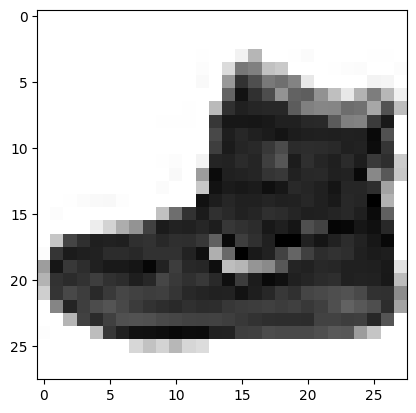

In [35]:
b = next(iter(dl)) # b is a dict
xb = b['image']  # xb is a minibatch
img = xb[0] # img is a single image
plt.imshow(img[0]);

In [36]:
type(b), xb.shape, img.shape

(dict, torch.Size([16, 1, 28, 28]), torch.Size([1, 28, 28]))

Let's define `show_image()`, which calls `imshow()`, and does a few extra things to ensure that: 
(1) it's in the correct axes order, (2) that's on the CPU,
(3) If it's not a NumPy array, convert it to a NumPy array, (4) set the size.
We'll be able to pass in an existing axis, set a title if we want to.
And remove the ugly axis because we're showing an image.

In [37]:
#|export
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0) #correct axis order
    elif not isinstance(im,np.ndarray): im=np.array(im) # convert to np
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

In [38]:
help(show_image)

Help on function show_image in module __main__:

show_image(im, ax=None, figsize=None, title=None, noframe=True, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, colorizer=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    Show a PIL or PyTorch image on `ax`.



When you ask for help on a function, it often shows features beyond its direct implementation. 
This is enabled by `**kwargs` and the `@delegates` decorator from fastcore.
<br>
`**kwargs` in a function's definition allows it to accept any number of extra, unnamed arguments, which are collected into a dictionary called `kwargs`. 
When the function is called and `**kwargs` is passed along (e.g., to `imshow()` using `**kwargs`), these extra arguments are unpacked and treated as individual arguments for that target function.
<br>
The `@delegates` decorator automatically pulls documentation from the function where kwargs is being passed (like `imshow()`) and includes it in the help output of the original function. This effectively extends the functionality and documentation of the original function by leveraging the capabilities of the delegated function through `**kwargs`.

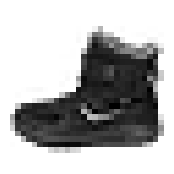

In [39]:
show_image(img, figsize=(2,2));

[Matplotlib subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html) are useful, e.g., **to plot two images next to each other**.
`Matplotlib.subplots` creates multiple plots, where we pass the number of rows and columns, and it returns "axes", 
which are the individual plots.
Below we call `show_image()` on the first image `xb[0]`, passing in `axs[0]`, and a second image `xb[1]` on the second axis, etc.

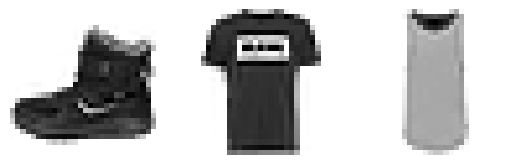

In [40]:
fig,axs = plt.subplots(1,3)
show_image(xb[0], axs[0])
show_image(xb[1], axs[1]);
show_image(xb[2], axs[2]);

Lets add additional functionality to `subplots`, using `@delegates`. 
We take `kwargs` and pass it through to  `subplots()`.
The goal is to automatically create an appropriate figure size,
and be able to add a title for the whole set of subplots.  

In [41]:
#|export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches."
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = array([ax])
    return fig,ax

In [42]:
from nbdev.showdoc import show_doc

`nvdev.showdoc` will automatically create documentation for the library. 
For the stuff we added, it's telling what each of these parameters is, 
their type, defaults, and information about each one.  
That information is automatically coming from the comments inside the function definition. 
We call these documents.
This is all automatic stuff done by fastcore and  nbdev. 

In [43]:
show_doc(subplots)

---

### subplots

>      subplots (nrows:int=1, ncols:int=1, figsize:tuple=None, imsize:int=3,
>                suptitle:str=None,
>                sharex:"bool|Literal['none','all','row','col']"=False,
>                sharey:"bool|Literal['none','all','row','col']"=False,
>                squeeze:bool=True, width_ratios:Sequence[float]|None=None,
>                height_ratios:Sequence[float]|None=None,
>                subplot_kw:dict[str,Any]|None=None,
>                gridspec_kw:dict[str,Any]|None=None, **kwargs)

*A figure and set of subplots to display images of `imsize` inches.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| nrows | int | 1 | Number of rows in returned axes grid |
| ncols | int | 1 | Number of columns in returned axes grid |
| figsize | tuple | None | Width, height in inches of the returned figure |
| imsize | int | 3 | Size (in inches) of images that will be displayed in the returned figure |
| suptitle | str | None | Title to be set to returned figure |
| sharex | bool \| Literal['none', 'all', 'row', 'col'] | False |  |
| sharey | bool \| Literal['none', 'all', 'row', 'col'] | False |  |
| squeeze | bool | True |  |
| width_ratios | Sequence[float] \| None | None |  |
| height_ratios | Sequence[float] \| None | None |  |
| subplot_kw | dict[str, Any] \| None | None |  |
| gridspec_kw | dict[str, Any] \| None | None |  |
| kwargs | VAR_KEYWORD |  |  |

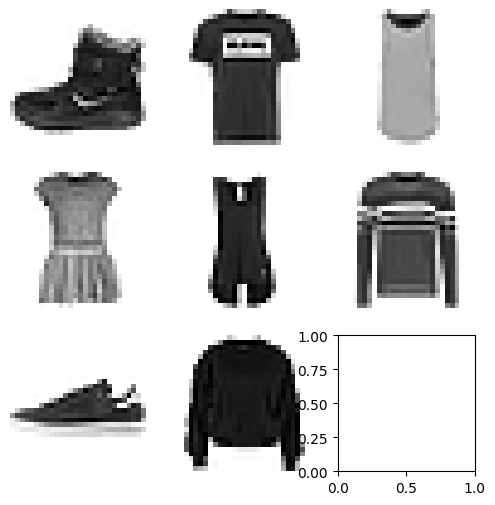

In [44]:
fig,axs = subplots(3,3, imsize=2)
imgs = xb[:8]
for ax,img in zip(axs.flat,imgs): show_image(img, ax)

Lets fix the above 9th box ugliness.

In [45]:
#|export
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.ceil(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

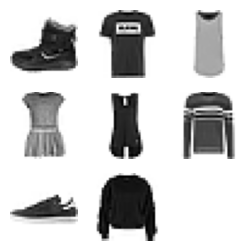

In [46]:
fig,axs = get_grid(8, nrows=3, imsize=1)
for ax,img in zip(axs.flat,imgs): show_image(img, ax)

In [47]:
#|export
@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int=1, # Number of rows in grid
                ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

In [48]:
yb = b['label']
lbls = yb[:8]

In [49]:
names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()
titles = itemgetter(*lbls)(names)
' '.join(titles)

'Boot Top Top Dress Top Pullover Sneaker Pullover'

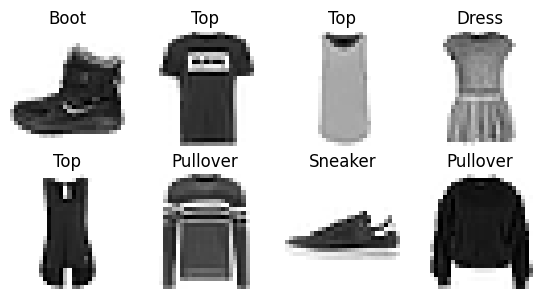

In [50]:
show_images(imgs, imsize=1.7, titles=titles)

`class DataLoaders:` defined similar to before.
We pass 2 dataloaders `dls[:2]` and store them in `.train`, `.valid`.
<br>
We define a `@classmethod` `from_dd()`, that calls `DataLoader` on each of the `ds` 
(dataset dictionary items), with the `batch_size` and instantiate the class.
NB: `cls` is the corresponding `self`.
<br>
Python's [@classmethod](https://docs.python.org/3/library/functions.html#classmethod)
allows us to later write `DataLoaders.`something, e.g., `DataLoaders.from_dd`.
NB: 
We could have put this in `__init__()`.
Nothing on the device because that didn't work (previous notebook).

In [51]:
#|export
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))
     

## Export -

In [52]:
import nbdev; nbdev.nbdev_export()